import packages

In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
from osgeo import gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
 
from torch import nn
from torch.nn import functional as F
 

In [50]:
!pip install segmentation-models-pytorch==0.1.0
!pip install keras-unet

 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [51]:
import segmentation_models_pytorch as smp
from keras_unet.utils import plot_imgs


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [167]:
size = 64
bs = 16 #batchsize
classes = [ 1, 2, 4,  5,  6,  7,  8,  9, 10, 15]
num_class= len(classes)
EPOCH= 50

Used to crop the imput images

In [168]:
def slice (arr, size, inputsize,stride):
    result = []
    if stride is None:
        stride = size
    for i in range(0, (inputsize-size)+1, stride):
        for j in range(0, (inputsize-size)+1, stride):
        
            if arr.ndim == 3:
                s = arr[:,i:(i+size),j:(j+size), ]
            else:
                s = arr[i:(i+size),j:(j+size), ]
            result.append(s)
 
 
    result = np.array(result)
    return result

def batchslice (arr, size, inputsize, stride, num_img):
    result = []
    for i in range(0, num_img):
        s= slice(arr[i,], size, inputsize, stride )
        result.append(s )
    result = np.array(result)
    result = result.reshape(result.shape[0]*result.shape[1], result.shape[2], result.shape[3], -1)
    return result


load the different tiles into 1 variable

In [169]:
reduce = 16
#stack all files into 1 variable
def load_raster(path,data,tile1,tile2):
   tiles_in=[tile1,tile2]
   files = []
   for tile in tiles_in:
       for file in glob.glob(path+data+'*{}.tif'.format(tile)):
           file1 = gdal_array.LoadFile(file)
           #only use 50% of the points to reduce memory
           if np.ndim(file1)==3:
               file1=file1[:,::reduce,::reduce]
           else:
               file1=file1[::reduce,::reduce]
           files.append(file1)
   stacked = np.array(files)
   return stacked

def load_data(path,data1,data2,tile1,tile2):
   part1 = load_raster(path,data1,tile1,tile2)
   part2 = load_raster(path,data2,tile1,tile2)
   print(part1.shape,part2.shape)
   if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
       part1 = np.expand_dims(part1,axis=1)
   elif np.ndim(part1)> np.ndim(part2):
       part2 = np.expand_dims(part2,axis=1)
   print(part1.shape,part2.shape)
   total = np.concatenate((part1,part2),axis=1)
   return total



(2, 1000, 1000) (2, 3, 1000, 1000)
(2, 1, 1000, 1000) (2, 3, 1000, 1000)


Slice input data into smaller size images

In [170]:
training= load_data("../input/guided-research/Training/","DEM","Wadden","12_7","13_8")
validation = load_data("../input/guided-research/Validation/","DEM","Wadden","12_8","14_7")
y_train= load_raster("../input/guided-research/Training/","class","12_7","13_8")
y_val=load_raster("../input/guided-research/Validation/","class","12_8","14_7")

(2, 1000, 1000) (2, 3, 1000, 1000)
(2, 1, 1000, 1000) (2, 3, 1000, 1000)


In [171]:
print(training.shape, validation.shape,y_train.shape, y_val.shape)

(2, 4, 1000, 1000) (2, 4, 1000, 1000) (2, 1000, 1000) (2, 1000, 1000)


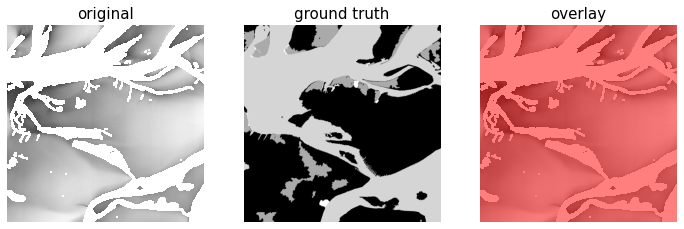

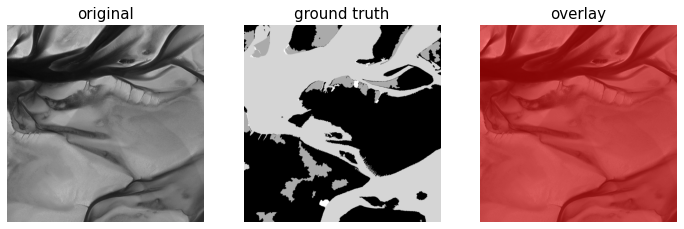

In [172]:

plot_imgs(
    org_imgs=training[1:2,0,:,:], # required - original images
    mask_imgs=y_train[1:2,:,:], # required - ground truth masks
    
    nm_img_to_plot=3) # optional - number of images to plot

plot_imgs(
    org_imgs=training[1:2,2,:,:], # required - original images
    mask_imgs=y_train[1:2,:,:], # required - ground truth masks
    
    nm_img_to_plot=3) # optional - number of images to plot

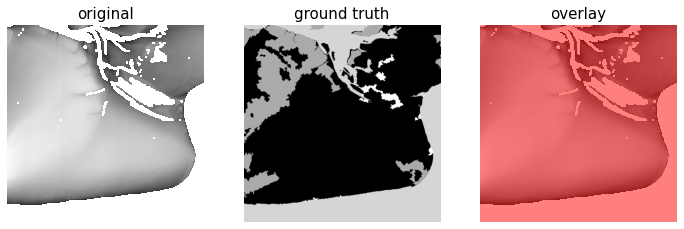

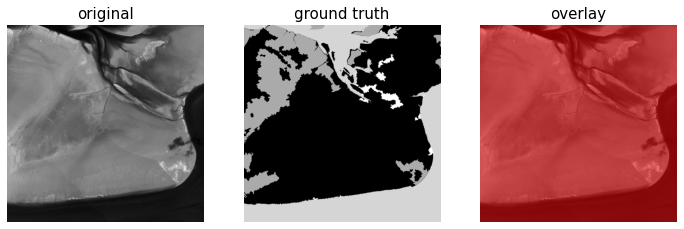

In [142]:
#np.moveaxis(validation[0:2,[1,2,3], :,:], 1 , -1)
plot_imgs(
    org_imgs=validation[1:2,0, :,:], # required - original images
    mask_imgs=y_val[1:2,:,:], # required - ground truth masks
    
    nm_itraining= load_data("../input/guided-research/Training/","DEM","Wadden","12_7","13_8")mg_to_plot=3) # optional - number of images to plot
plot_imgs(
    org_imgs=validation[1:2,1, :,:], # required - original images
    mask_imgs=y_val[1:2,:,:], # required - ground truth masks
    
    nm_img_to_plot=3) # optional - number of images to plot

(1, 1000, 1000, 3)
(2, 4, 1000, 1000)


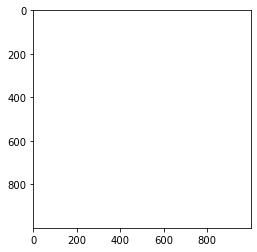

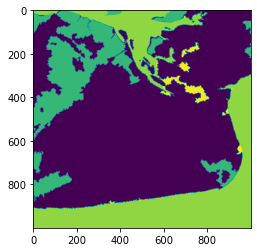

In [135]:
#a= np.moveaxis(validation[1:2 ,1:4,:,:], 1, -1)
 

In [182]:
training.shape

(2, 4, 1000, 1000)

In [184]:
training  = batchslice(training,size,training[0].shape[1],size,training.shape[0])
validation=batchslice(validation,size,validation[0].shape[1],size,validation.shape[0])

y_train = batchslice(y_train,size,y_train[0].shape[1],size,y_train.shape[0]).squeeze()
y_val = batchslice(y_val,size,y_val[0].shape[1],size,y_val.shape[0]).squeeze()
  

print(training.shape,validation.shape,y_train.shape, y_val.shape)


(450, 4, 64, 64) (450, 4, 64, 64) (450, 64, 64) (450, 64, 64)


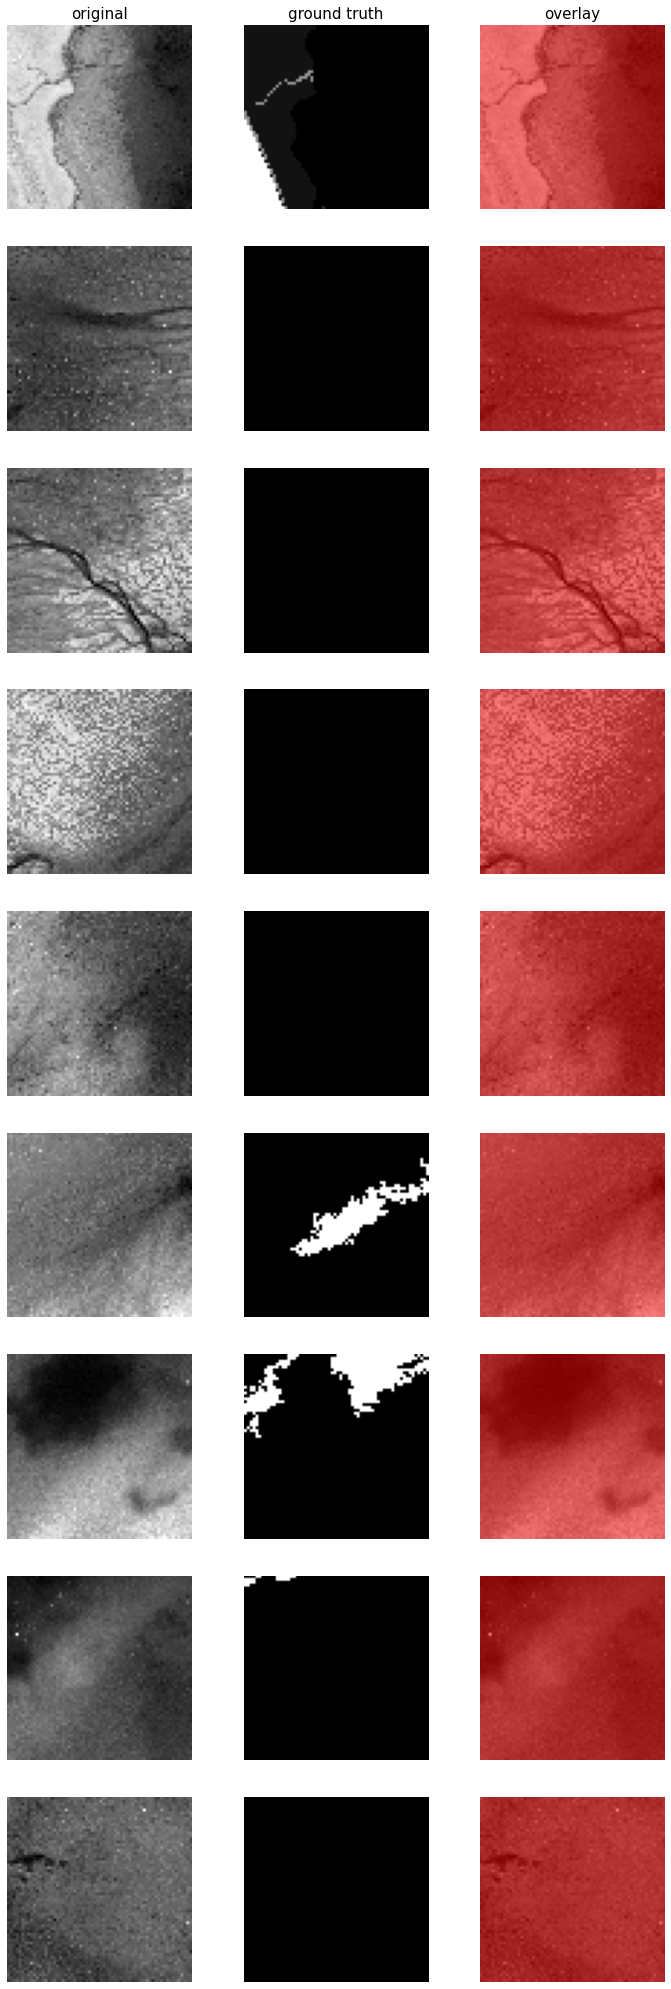

In [185]:
#plt.itraining= load_data("../input/guided-research/Training/","DEM","Wadden","12_7","13_8")mshow(validation[1,0,:,:])
#plt.show() 
plot_imgs(
    org_imgs=validation[0:9,1, :,:], # required - original images
    mask_imgs=y_val[0:9,:,:], # required - ground truth masks
    
    nm_img_to_plot=10) # optional - number of images to plot

In [ ]:
#for wh in range(10,20):
#    plt.imshow(validation[wh,0,:,:])
#    plt.show() 
#    plt.imshow(validation[wh,2,:,:])
#    plt.show() 
#    plt.imshow(y_val[wh,:,:])
#    plt.show()  

In [174]:
def class2dim (mask, CLASSES):
    
        masks = [(mask == v) for v in CLASSES ]
        mask = np.stack(masks, axis=-1).astype('float')    
        return mask



      

In [186]:
new_mask = class2dim(y_train, classes)
new_mas_val = class2dim(y_val, classes)

15 15


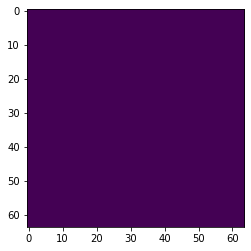

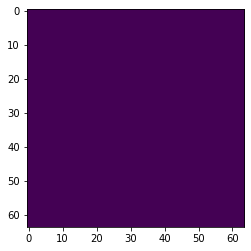

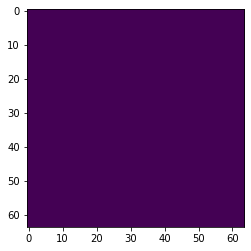

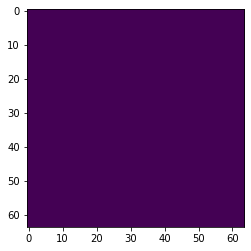

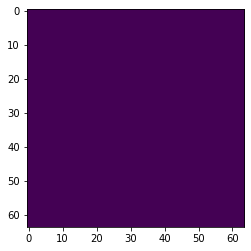

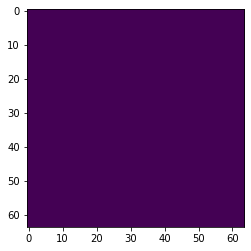

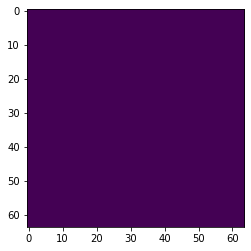

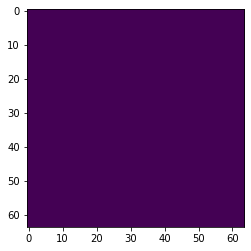

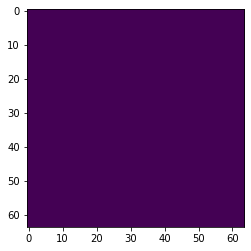

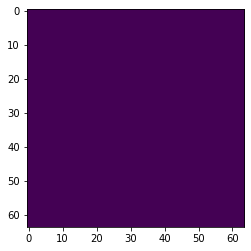

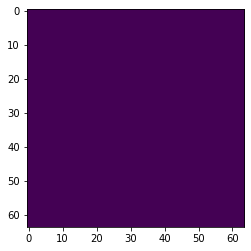

In [187]:
#check
#whichone = 5
#print(np.amax(y_train[whichone,] ),np.amin(y_train[whichone,] ))
#plt.imshow(y_train[whichone,] )
#plt.show() 
#for n in range(num_class): 
#    plt.imshow(new_mask[whichone,:,:,n])     
#    plt.show() 


Code used to see slicing result

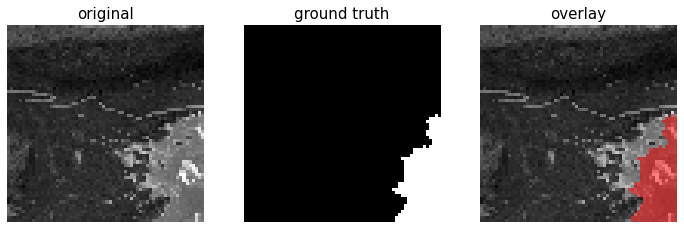

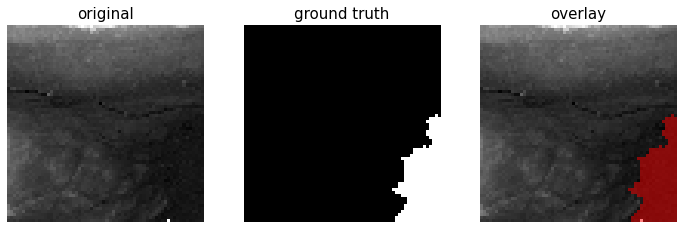

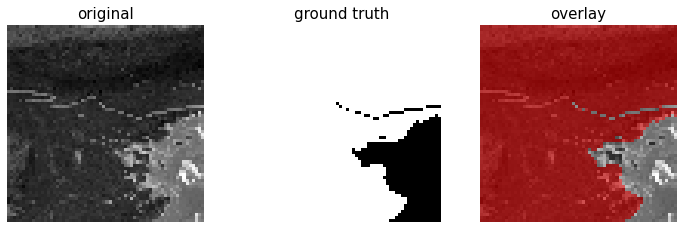

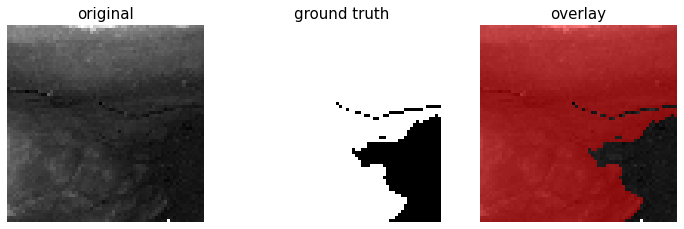

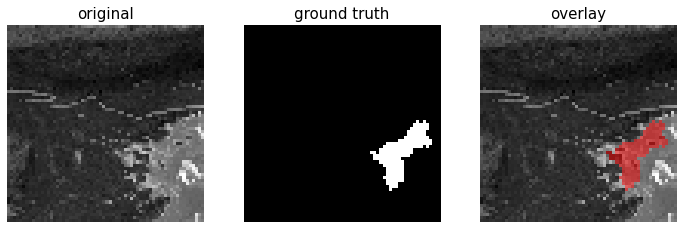

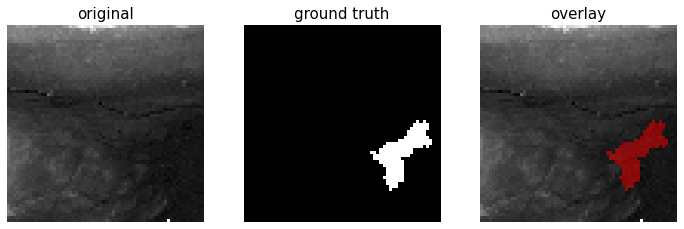

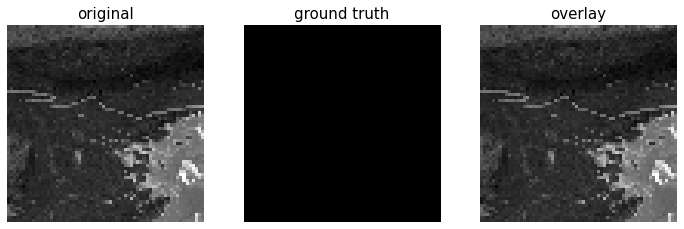

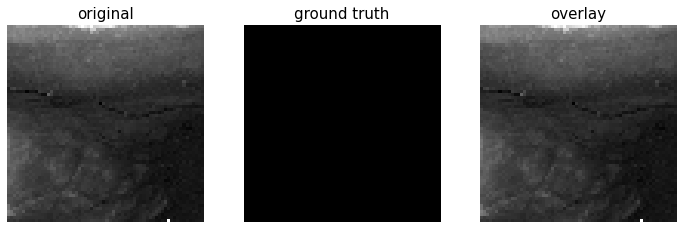

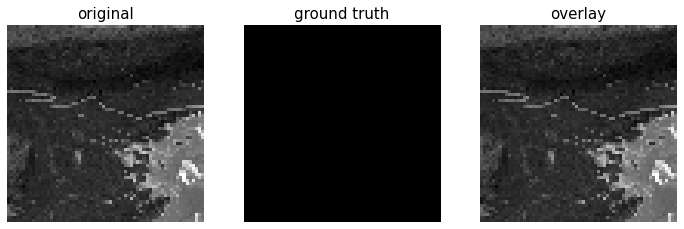

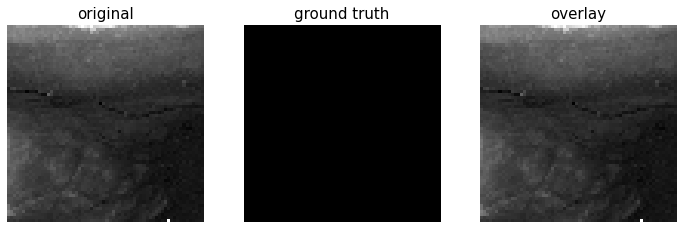

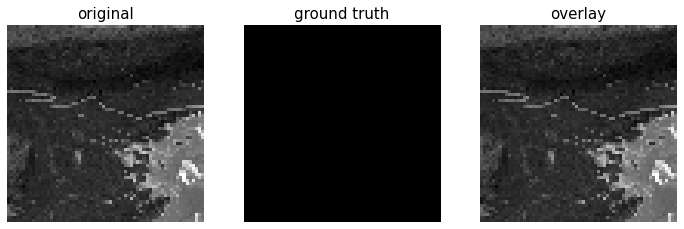

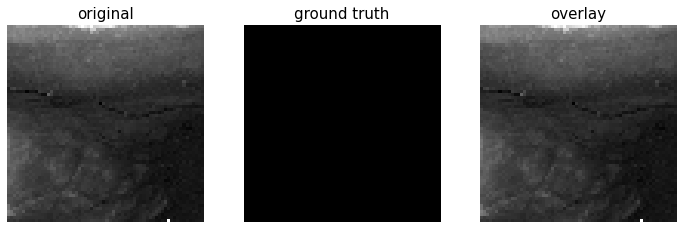

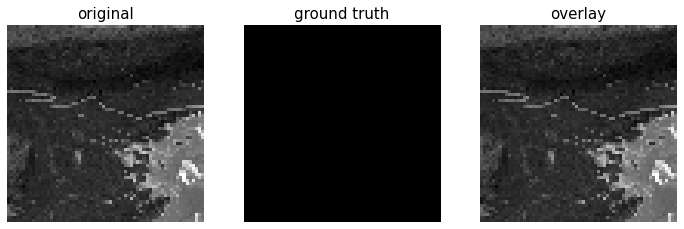

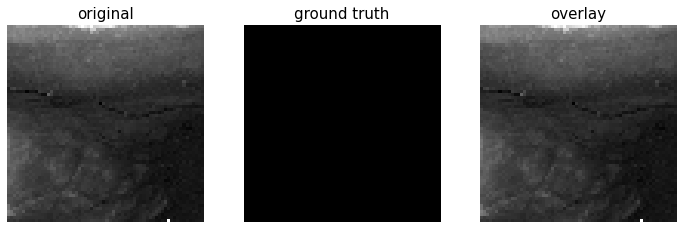

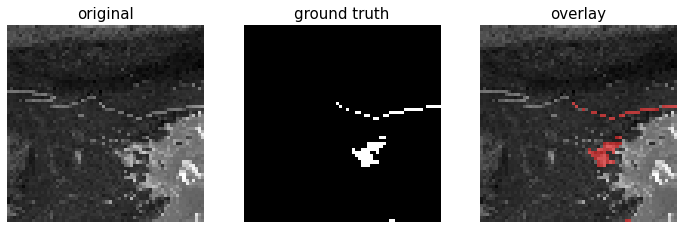

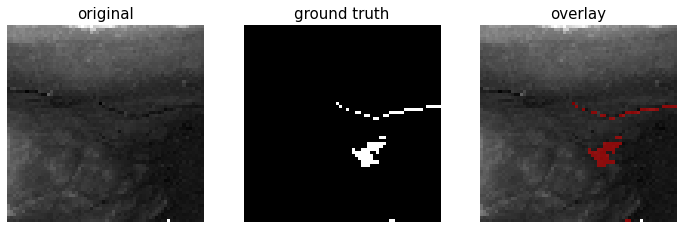

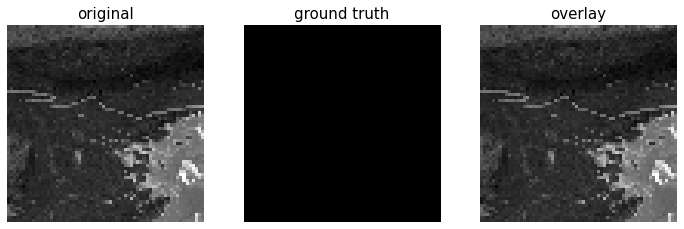

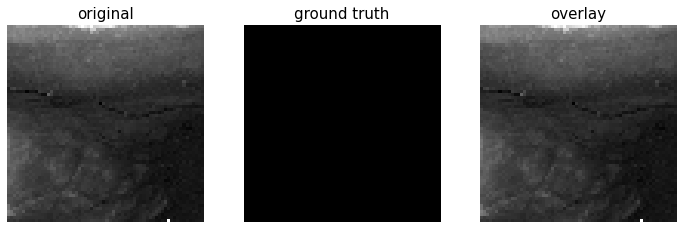

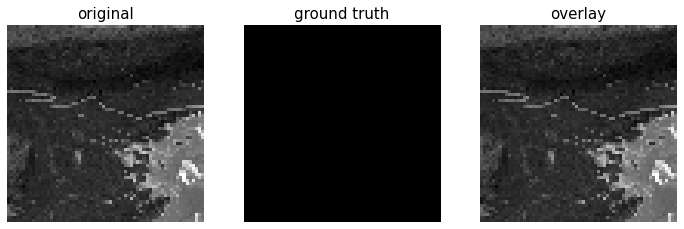

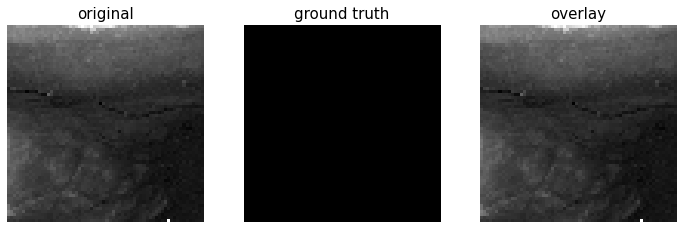

In [194]:
for i in range(len(classes)):
    plot_imgs(
    org_imgs=training[100:101, 2, :,: ],
    mask_imgs=new_mask[100:101,:,:,i], # required - original images 

    nm_img_to_plot=10) # optional - number of images to plot

    plot_imgs(
    org_imgs=training[100:101, 0, :,: ],
    mask_imgs=new_mask[100:101,:,:,i], # required - original images 

    nm_img_to_plot=10) # optional - number of images to plot

 


In [ ]:
new_mask =  np.moveaxis(new_mask, -1, 1)
new_mas_val = np.moveaxis(new_mas_val, -1, 1)

In [ ]:
training[training> 1e308] = 0 
#np.nan
validation[validation> 1e308] =0 
new_mask[new_mask >1e308] = 0
new_mas_val[new_mas_val> 1e308] = 0

In [ ]:
new_mask.shape

training = list(zip(training[:,1,:,:], y_train))
validation = list(zip(validation[:,1,:,:], y_val))m
 

In [ ]:
from torch.utils.data import DataLoader, TensorDataset 
def myloader(trainX, trainY, valX,valY):
    train = TensorDataset(torch.Tensor(trainX[:,0:3,:,:]), torch.Tensor(trainY )) # create your datset
    train  = DataLoader(train, batch_size=bs) # create your dataloader
    
    vali= TensorDataset(torch.Tensor(valX[:,0:3,:,:]),torch.Tensor(valY  )) # create your datset
    vali = DataLoader(vali, batch_size=bs) # create your dataloader
    return train , vali 


In [ ]:
#np.save("../wadden1", zip(training, new_mask, validation, new_mas_val))

Get torch loader, got the error in catalyst with "collection dont have attribute size", use original array as demonstrated in catalyst

In [ ]:
train_loader, valid_loader = myloader(training, new_mask, validation, new_mas_val)
 # torch.LongTensor() for some losses

In [ ]:
#net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')
#print(net)

In [ ]:
print(new_mask.shape)

In [ ]:
CLASSES = [format(x, '2d') for x in  classes]
 
model = smp.Unet(classes=len(CLASSES), in_channels=3,activation="sigmoid")
#newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
print(model)


In [ ]:
#model = net
print(CLASSES)

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

print(len(CLASSES))
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
#model = smp.FPN(
#    encoder_name=ENCODER, 
#    encoder_weights=ENCODER_WEIGHTS, 
#    classes=len(CLASSES), 
#    activation=ACTIVATION,
#)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

loss = smp.utils.losses.DiceLoss()
#loss=nn.BCELoss(reduction = 'sum')
#WithLogits
#loss = nn.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
max_score = 0

for i in range(0, EPOCH):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5

        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
best_model = torch.load('./best_model.pth')

In [ ]:
#best_model

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
for i in range(10):
    x_tensor = torch.from_numpy(validation[:,0:3,:,:]).to(DEVICE)     
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy())
        
    visualize( 
        predicted_mask=pr_mask[2,i,:,:]
    )
plt.imshow(validation[2,1,:,:])
plt.show()
plt.imshow(y_val[2,:,:])

In [ ]:
#comparison = training == validation
#equal_arrays = comparison.all()
#print(equal_arrays)
#inputs, masks = next(iter(loaders['valid']))
 

Pre-trained Unet segmentation model

In [ ]:
class myLoss(torch.nn.Module):

    def __init__(self, pos_weight=1):
      super().__init__()
      self.pos_weight = pos_weight

    def forward(self, input, target):
      epsilon = 10 ** -44
      input = input.sigmoid().clamp(epsilon, 1 - epsilon)

      my_bce_loss = -1 * (self.pos_weight * target * torch.log(input)
                          + (1 - target) * torch.log(1 - input))
      add_loss = (target - 0.5) ** 2 * 4
      mean_loss = (my_bce_loss * add_loss).mean()
      return mean_loss

  


In [ ]:
from catalyst.dl import utils
import collections
from catalyst.data import Augmentor
import torchvision.transforms as transforms

open_fn = lambda x: {"features": x[0], "targets": x[1]}
data_transform = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 255.)),
    Augmentor(
        dict_key="features",
        augment_fn=transforms.Normalize(
            (0.5, ),
            (0.5, ))),
    Augmentor(
        dict_key="targets",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 255.) )
])
#.unsqueeze_(0)


train_loader = utils.get_loader(
    list(zip(training.astype(np.float32), new_mask.astype(np.float32))), 
    open_fn=open_fn,  
    batch_size=bs, 
    dict_transform=data_transform, 
    num_workers=4, 
    shuffle=True)

valid_loader = utils.get_loader(
    list(zip(validation.astype(np.float32), new_mas_val.astype(np.float32))), 
    open_fn=open_fn,  
    batch_size=bs, 
    dict_transform=data_transform, 
    num_workers=4, 
    shuffle=False)

 
from catalyst.dl import utils
 
loaders = collections.OrderedDict()


loaders["train"] = train_loader
loaders["valid"] =valid_loader

In [ ]:
inputs, masks = next(iter(loaders['valid']))

%load_ext tensorboard
%tensorboard --logdir {logdir}

In [ ]:
from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback
# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}


callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

 

In [ ]:
from catalyst.contrib.models.cv import Unet,ResnetUnet
from catalyst.contrib.nn import DiceLoss, IoULoss, NLLLoss

from catalyst.dl import SupervisedRunner

# experiment setup
num_epochs =EPOCH
logdir = "segmentation_notebook"

# model, criterion, optimizer
#model =  torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=num_class)
#model =Unet(num_classes=num_class, in_channels=4, num_channels=64, num_blocks=4)# catalyst Unet
#model = ResnetUnet(num_classes=num_class) # can only take 3 channels 
model = smp.Unet(classes=num_class, in_channels=4, activation = "sigmoid")
print(model) 
criterion =nn.BCELoss()
#smp.utils.losses.DiceLoss()
#WithLogits 
#myLoss()
#nn.BCEWithLogitsLoss() # this and myLoss() can run but gradient does not descent. 
# nn.CrossEntropyLoss()  # the type should be Long
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 40], gamma=0.3)



# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    #callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True,
    main_metric='iou',
    callbacks=[ 
        IouCallback(),
    ],
    load_best_on_end=True,
)
 

In [ ]:
import inspect
inspect.signature(runner.train)

In [ ]:
runner_out = runner.predict_loader(loader=loaders["valid"])

In [ ]:
import math 

def sigmoid(x):
    return 1/(1 + np.exp(-x))
for i, output in enumerate (runner_out):
 
    plt.figure(figsize=(8,8))
    plt.imshow(output['logits'].cpu()[1,i,])    

In [ ]:
plt.imshow(validation[1,1,])

In [ ]:
for i, output in enumerate (runner_out):     
    for i in range(0,1): 
        plt.subplot(1, 3, 1)
        plt.imshow(output['logits'].cpu()[1,i,])
        plt.subplot(1, 3, 2)
        plt.imshow(validation[1,2,])
        plt.subplot(1, 3, 3)
        plt.imshow(new_mas_val[1,i,])

In [ ]:
for i in range(1,10): 
        plt.subplot( 10,3, 1+3*(i-1))
        plt.imshow(output['logits'].cpu()[1,i,])
        plt.subplot(10,3, 2+3*(i-1))
        plt.imshow(validation[1,2,])
        plt.subplot(10, 3, 3+3*(i-1))
        plt.imshow(new_mas_val[1,i,])

In [ ]:
for i, (input, output) in enumerate(zip(validation, runner_out)):
    image, mask = input
    
    threshold = 0.5
    
    plt.figure(figsize=(10,8))
    
    
    plt.imshow(image, 'gray')
    
    plt.subplot(1, 3, 2)
    output =  output["logits"].copy()
    output = (output > threshold).astype(np.uint8)
    plt.imshow(output, "gray")
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, "gray")
    
    plt.show()

In [ ]:
#plt.style.use("ggplot")
#%matplotlib inline

sigmoid = lambda x: 1/(1 + np.exp(-x))

for i, (input, output) in enumerate(zip(validation, runner_out)):
    image, mask = input
    
    threshold = 0.5
    
    plt.figure(figsize=(10,8))
    
    
    plt.imshow(image, 'gray')
    
    plt.subplot(1, 3, 2)
    output =  output["logits"].copy()
    output = (output > threshold).astype(np.uint8)
    plt.imshow(output, "gray")
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, "gray")
    
    plt.show()

How to update a model
https://heartbeat.fritz.ai/image-segmentation-with-transfer-learning-pytorch-5ada7121c6ab

#for loop way of class2dimm
def class2dim2 (mask, num_class):
    
    new_mask = np.reshape(np.tile(mask, num_class), ( mask.shape[0], mask.shape[1],mask.shape[2], num_class))
 
    for j in range(mask.shape[0]):
         aslice = new_mask[j,]
         amask = mask[j,]
         for i in range(num_class):
             aslice[:,:,i] = np.multiply(amask == i+1,1)        
         new_mask[j,]=aslice
    return new_mask
    
a = class2dim2(y_train, num_class)
a.shape
comparison = a == new_mask
equal_arrays = comparison.all()
print(equal_arrays)



